In [1]:
###### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rnd
from tqdm import tqdm_notebook #gives a progress bar

# visualizatoin
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
plt.style.use('ggplot')

# Feature Importance
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBRegressor


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
train = pd.read_csv('../input/predict-future-sales-eda/Training_Data.csv')

categories = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")

test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")



## Initialize

In [2]:
train.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month,Month,m_num
0,0,2,5572,2.0,10730.0,9.0,Jan,1
1,0,2,5643,2.0,2390.0,1.0,Jan,1
2,0,2,5583,5.0,1188.3,2.0,Jan,1
3,0,2,7893,6.0,5970.0,3.0,Jan,1
4,0,2,7894,6.0,1490.0,1.0,Jan,1


In [3]:
train.shape

(6734302, 8)

In [4]:
test.tail()

,ID,shop_id,item_id
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


Test only has shop_id and item_id. Doesn't need date_block_num because we already know the test data is for month 34, so they will all be the same. Doesn't need item_cnt_day because that is what we are trying to find. Excetp for the whole month. 

We need to drop the ID column because there are two with the same for test.

In [5]:
test.drop('ID', axis=1, inplace=True)

In [6]:
test.tail()

,shop_id,item_id
214195,45,18454
214196,45,16188
214197,45,15757
214198,45,19648
214199,45,969


In [7]:
print("test: ", test.item_id.agg([min, max]))
print("train: ", train.item_id.agg([min, max]))

test:  min       30
max    22167
Name: item_id, dtype: int64
train:  min       30
max    22167
Name: item_id, dtype: int64


This shows they share some of the same items being sold.

In [8]:
train.nunique()

date_block_num         34
shop_id                42
item_id              4716
item_category_id       61
item_price          26304
item_cnt_month        196
Month                  12
m_num                  12
dtype: int64

In [9]:
print("test: ", test.shop_id.agg([min, max]))
print("test: ", train.shop_id.agg([min, max]))

test:  min     2
max    59
Name: shop_id, dtype: int64
test:  min     2
max    59
Name: shop_id, dtype: int64


### Feature Engineering: Test

Create new features in the test set that we know will be constant
1. date_block_num: 34
2. Month: Nov
3. m_num: 11


In [10]:
traintest = pd.concat([train, test], axis=0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [11]:
traintest.tail()

,Month,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id
214195,NaN,NaN,NaN,NaN,18454,NaN,NaN,45
214196,NaN,NaN,NaN,NaN,16188,NaN,NaN,45
214197,NaN,NaN,NaN,NaN,15757,NaN,NaN,45
214198,NaN,NaN,NaN,NaN,19648,NaN,NaN,45
214199,NaN,NaN,NaN,NaN,969,NaN,NaN,45


In [12]:
traintest.nunique(dropna=False)

Month                  13
date_block_num         35
item_category_id       62
item_cnt_month        197
item_id              5100
item_price          26305
m_num                  13
shop_id                42
dtype: int64

So there are 22,166 total item_id's in the combined train and test data. There were 21,803 unique item_id names in the train data. This means that there are only 363 unique items in the new combined data that do not have historical monthly returns in the train data (could be higher than 363 if the new unique values keep appearing over and over again). 

For the test in the new dataset, non of the columns have values except for item_id and shop_id. We need to fill all the other columns we can. 

### Fill NaN Values in Traintest

We can fill values in the columns below because we know what month all of the test data is in.

In [13]:
values = {'Month': 'Nov', 'date_block_num': 34, 'm_num': 11}
traintest = traintest.fillna(value=values)

In [14]:
traintest.tail()

,Month,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id
214195,Nov,34.0,NaN,NaN,18454,NaN,11.0,45
214196,Nov,34.0,NaN,NaN,16188,NaN,11.0,45
214197,Nov,34.0,NaN,NaN,15757,NaN,11.0,45
214198,Nov,34.0,NaN,NaN,19648,NaN,11.0,45
214199,Nov,34.0,NaN,NaN,969,NaN,11.0,45


# Feature Engineering

We are going to drop all the categories that are not useful, and then use feature engineering (mostly with price and monthly sales) to create new columns. Then we will determine if they are just duplicates or if they provide any new correlations with montly sales. 

1. Basic Prices
2. Map by item categories
3. Grouped Features
4. Lag features (features using lagging data or previous month data)
5. Mean
6. Drop Items

### 1. Basic Prices

**Revenue**

In [15]:
traintest['Revenue'] = traintest['item_price']*traintest['item_cnt_month']
traintest.head()

,Month,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id,Revenue
0,Jan,0.0,2.0,9.0,5572,10730.0,1.0,2,96570.0
1,Jan,0.0,2.0,1.0,5643,2390.0,1.0,2,2390.0
2,Jan,0.0,5.0,2.0,5583,1188.3,1.0,2,2376.6
3,Jan,0.0,6.0,3.0,7893,5970.0,1.0,2,17910.0
4,Jan,0.0,6.0,1.0,7894,1490.0,1.0,2,1490.0


**Year**

In [16]:
# change date_block_num to int
traintest = traintest.astype({'date_block_num': 'int64'})

In [17]:
traintest.dtypes

Month                object
date_block_num        int64
item_category_id    float64
item_cnt_month      float64
item_id               int64
item_price          float64
m_num               float64
shop_id               int64
Revenue             float64
dtype: object

In [18]:
# Map
traintest['year'] = traintest['date_block_num'].map({0:'2013', 1:'2013', 2:'2013', 3:'2013', 4:'2013', 5:'2013', 6:'2013', 7:'2013', 8:'2013', 9:'2013', 10:'2013', 11:'2013',
                                                    12: '2014', 13: '2014', 14:'2014', 15:'2014', 16:'2014', 17:'2014', 18:'2014', 19:'2014', 20:'2014', 21:'2014', 22:'2014', 23:'2014',
                                                    24: '2015', 25:'2015', 26:'2015', 27:'2015', 28:'2015', 29:'2015', 30:'2015', 31:'2015', 32:'2015', 33:'2015', 34:'2015'
                                                    })

traintest = traintest.astype({'year': 'int64'})
traintest.head()

,Month,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id,Revenue,year
0,Jan,0,2.0,9.0,5572,10730.0,1.0,2,96570.0,2013
1,Jan,0,2.0,1.0,5643,2390.0,1.0,2,2390.0,2013
2,Jan,0,5.0,2.0,5583,1188.3,1.0,2,2376.6,2013
3,Jan,0,6.0,3.0,7893,5970.0,1.0,2,17910.0,2013
4,Jan,0,6.0,1.0,7894,1490.0,1.0,2,1490.0,2013


### 2. Map by Category

For now we are going to leave off any categories because some of the train data doesn't have it.

We are going to map this by category and encode a number to each range of date_block_num. This will make it easier to model. This is done by looking at each item category and grouping them together by what they sell.

### 3. Grouped Features

Find max price for each item (no need for min because it will be zero)


In [19]:
# we are going to create another dataset with the min and max and then join it to traintest
# we do this because it is easier to sort the values
group_price = traintest.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price': np.max})
group_price.columns = (['item_id', 'max_item_price'])

traintest = pd.merge(traintest, group_price, on ='item_id', how='left')
traintest.head()

,Month,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id,Revenue,year,max_item_price
0,Jan,0,2.0,9.0,5572,10730.0,1.0,2,96570.0,2013,18979.5
1,Jan,0,2.0,1.0,5643,2390.0,1.0,2,2390.0,2013,35260.0
2,Jan,0,5.0,2.0,5583,1188.3,1.0,2,2376.6,2013,5592.0
3,Jan,0,6.0,3.0,7893,5970.0,1.0,2,17910.0,2013,42630.0
4,Jan,0,6.0,1.0,7894,1490.0,1.0,2,1490.0,2013,31290.0


Find max price for each shop

In [20]:
groups_price = traintest.sort_values('date_block_num').groupby(['shop_id'], as_index=False).agg({'item_price': np.max})
groups_price.columns = (['shop_id', 'shop_max_price'])

traintest = pd.merge(traintest, groups_price, on ='shop_id', how='left')
traintest.head()

,Month,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id,Revenue,year,max_item_price,shop_max_price
0,Jan,0,2.0,9.0,5572,10730.0,1.0,2,96570.0,2013,18979.5,274298.571428
1,Jan,0,2.0,1.0,5643,2390.0,1.0,2,2390.0,2013,35260.0,274298.571428
2,Jan,0,5.0,2.0,5583,1188.3,1.0,2,2376.6,2013,5592.0,274298.571428
3,Jan,0,6.0,3.0,7893,5970.0,1.0,2,17910.0,2013,42630.0,274298.571428
4,Jan,0,6.0,1.0,7894,1490.0,1.0,2,1490.0,2013,31290.0,274298.571428


Max number of items sold

In [21]:
# max number of items per item id
group_item = traintest.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_cnt_month':  np.max})
group_item.columns = (['item_id', 'max_item_cnt'])

traintest = pd.merge(traintest, group_item, on ='item_id', how='left')

# max number of items sold per shop id
groups_item = traintest.sort_values('date_block_num').groupby(['shop_id'], as_index=False).agg({'item_cnt_month': np.max})
groups_item.columns = (['shop_id', 'shop_max_cnt'])

traintest = pd.merge(traintest, groups_item, on = 'shop_id', how='left')

traintest.head()

,Month,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id,Revenue,year,max_item_price,shop_max_price,max_item_cnt,shop_max_cnt
0,Jan,0,2.0,9.0,5572,10730.0,1.0,2,96570.0,2013,18979.5,274298.571428,17.0,96.0
1,Jan,0,2.0,1.0,5643,2390.0,1.0,2,2390.0,2013,35260.0,274298.571428,23.0,96.0
2,Jan,0,5.0,2.0,5583,1188.3,1.0,2,2376.6,2013,5592.0,274298.571428,9.0,96.0
3,Jan,0,6.0,3.0,7893,5970.0,1.0,2,17910.0,2013,42630.0,274298.571428,38.0,96.0
4,Jan,0,6.0,1.0,7894,1490.0,1.0,2,1490.0,2013,31290.0,274298.571428,37.0,96.0


In [22]:
traintest.tail()

,Month,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id,Revenue,year,max_item_price,shop_max_price,max_item_cnt,shop_max_cnt
6948497,Nov,34,NaN,NaN,18454,NaN,11.0,45,NaN,2015,2189.0,283890.0,13.0,89.0
6948498,Nov,34,NaN,NaN,16188,NaN,11.0,45,NaN,2015,1359.0,283890.0,1.0,89.0
6948499,Nov,34,NaN,NaN,15757,NaN,11.0,45,NaN,2015,796.0,283890.0,4.0,89.0
6948500,Nov,34,NaN,NaN,19648,NaN,11.0,45,NaN,2015,297.0,283890.0,4.0,89.0
6948501,Nov,34,NaN,NaN,969,NaN,11.0,45,NaN,2015,5490.0,283890.0,13.0,89.0


#### Fill Missing Features

In [23]:
train_shop_mean = traintest[traintest['date_block_num'] == 34]

In [24]:
# Fill NaN's with avg
traintest['max_item_price'].fillna((train_shop_mean['max_item_price'].mean()), inplace=True)
traintest['max_item_cnt'].fillna((train_shop_mean['max_item_cnt'].mean()), inplace=True)

In [25]:
traintest.tail(30)

,Month,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id,Revenue,year,max_item_price,shop_max_price,max_item_cnt,shop_max_cnt
6948472,Nov,34,NaN,NaN,14543,NaN,11.0,45,NaN,2015,499.000000,283890.0,1.000000,89.0
6948473,Nov,34,NaN,NaN,19253,NaN,11.0,45,NaN,2015,3887.000000,283890.0,14.000000,89.0
6948474,Nov,34,NaN,NaN,17957,NaN,11.0,45,NaN,2015,12451.000000,283890.0,10.000000,89.0
6948475,Nov,34,NaN,NaN,12470,NaN,11.0,45,NaN,2015,6296.064344,283890.0,10.016115,89.0
6948476,Nov,34,NaN,NaN,7543,NaN,11.0,45,NaN,2015,2093.000000,283890.0,7.000000,89.0
6948477,Nov,34,NaN,NaN,6661,NaN,11.0,45,NaN,2015,2995.000000,283890.0,6.000000,89.0
6948478,Nov,34,NaN,NaN,11137,NaN,11.0,45,NaN,2015,299.000000,283890.0,1.000000,89.0
6948479,Nov,34,NaN,NaN,11489,NaN,11.0,45,NaN,2015,4188.000000,283890.0,21.000000,89.0
6948480,Nov,34,NaN,NaN,9782,NaN,11.0,45,NaN,2015,6493.000000,283890.0,10.000000,89.0
6948481,Nov,34,NaN,NaN,2972,NaN,11.0,45,NaN,2015,10183.000000,283890.0,44.000000,89.0


### 4. Lag Features


Create column with revenue of previous month
items_sold_mean previous month
items_sold_sum previous month

Use hyperparamter optimization to find out which lagging monthly window is the best (3-month, 6-month, etc.)
We can probably use XGBoost to determine that. 

#### Lagging Monthly Sales

In [26]:
# Previous Month sales
traintest['prev_month_itm_cnt'] = traintest.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(1)
traintest['prev_month_itm_cnt'].fillna(0, inplace=True)


# 6-month Avg
#s_min = lambda x: x.rolling(window=6, min_periods=1).min()
# Max value
#s_max = lambda x: x.rolling(window=6, min_periods=1).max()
# Mean value
s_mean = lambda x: x.rolling(window=6, min_periods=1).mean()
# Standard deviation
#s_std = lambda x: x.rolling(window=6, min_periods=1).std()

#six_month_list = [s_min, s_max, s_mean, s_std]
#funct_name = ['min', 'max', 'mean', 'std']

#for i in range(len(six_month_list)):
#    traintest[('6_month_item_cnt_%s' % funct_name[i])] = traintest.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt_day'].apply(six_month_list[i])
    
traintest['6_mnth_mvg_avg'] = traintest.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt_month'].apply(s_mean)
# Fill the empty std features with 0
#traintest['6_month_item_cnt_std'].fillna(0, inplace=True)

traintest['6_mnth_mvg_avg'].fillna(0, inplace=True)

# 12-month Avg (yearly average)

t_mean = lambda x: x.rolling(window=12, min_periods=1).mean()

traintest['12_mnth_mvg_avg'] = traintest.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt_month'].apply(t_mean)
traintest['12_mnth_mvg_avg'].fillna(0, inplace=True)

In [27]:
traintest.head()

,Month,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id,Revenue,year,max_item_price,shop_max_price,max_item_cnt,shop_max_cnt,prev_month_itm_cnt,6_mnth_mvg_avg,12_mnth_mvg_avg
0,Jan,0,2.0,9.0,5572,10730.0,1.0,2,96570.0,2013,18979.5,274298.571428,17.0,96.0,0.0,9.0,9.0
1,Jan,0,2.0,1.0,5643,2390.0,1.0,2,2390.0,2013,35260.0,274298.571428,23.0,96.0,0.0,1.0,1.0
2,Jan,0,5.0,2.0,5583,1188.3,1.0,2,2376.6,2013,5592.0,274298.571428,9.0,96.0,0.0,2.0,2.0
3,Jan,0,6.0,3.0,7893,5970.0,1.0,2,17910.0,2013,42630.0,274298.571428,38.0,96.0,0.0,3.0,3.0
4,Jan,0,6.0,1.0,7894,1490.0,1.0,2,1490.0,2013,31290.0,274298.571428,37.0,96.0,0.0,1.0,1.0


In [28]:
traintest.tail()

,Month,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id,Revenue,year,max_item_price,shop_max_price,max_item_cnt,shop_max_cnt,prev_month_itm_cnt,6_mnth_mvg_avg,12_mnth_mvg_avg
6948497,Nov,34,NaN,NaN,18454,NaN,11.0,45,NaN,2015,2189.0,283890.0,13.0,89.0,1.0,0.2,0.818182
6948498,Nov,34,NaN,NaN,16188,NaN,11.0,45,NaN,2015,1359.0,283890.0,1.0,89.0,0.0,0.0,0.000000
6948499,Nov,34,NaN,NaN,15757,NaN,11.0,45,NaN,2015,796.0,283890.0,4.0,89.0,0.0,0.0,0.181818
6948500,Nov,34,NaN,NaN,19648,NaN,11.0,45,NaN,2015,297.0,283890.0,4.0,89.0,0.0,0.0,0.000000
6948501,Nov,34,NaN,NaN,969,NaN,11.0,45,NaN,2015,5490.0,283890.0,13.0,89.0,0.0,0.0,0.000000


### 5. Mean

Split train and test data

In [29]:
# test dataframe
test_df = traintest[traintest['date_block_num'] == 34]

# train dataframe
train_df = traintest[traintest['date_block_num'] < 34]
train_df.tail()

,Month,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id,Revenue,year,max_item_price,shop_max_price,max_item_cnt,shop_max_cnt,prev_month_itm_cnt,6_mnth_mvg_avg,12_mnth_mvg_avg
6734297,Oct,33,0.0,0.0,9103,0.0,10.0,36,0.0,2015,500.0,28392.0,11.0,16.0,0.0,0.0,0.0
6734298,Oct,33,0.0,0.0,9107,0.0,10.0,36,0.0,2015,300.0,28392.0,6.0,16.0,0.0,0.0,0.0
6734299,Oct,33,0.0,0.0,5704,0.0,10.0,36,0.0,2015,1750.0,28392.0,1.0,16.0,0.0,0.0,0.0
6734300,Oct,33,0.0,0.0,12733,0.0,10.0,36,0.0,2015,2980.0,28392.0,2.0,16.0,0.0,0.0,0.0
6734301,Oct,33,0.0,0.0,15925,0.0,10.0,36,0.0,2015,11899.0,28392.0,1.0,16.0,0.0,0.0,0.0


In [30]:
test_df.head()

,Month,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id,Revenue,year,max_item_price,shop_max_price,max_item_cnt,shop_max_cnt,prev_month_itm_cnt,6_mnth_mvg_avg,12_mnth_mvg_avg
6734302,Nov,34,NaN,NaN,5037,NaN,11.0,5,NaN,2015,25990.000000,217310.0,23.000000,155.0,0.0,1.2,1.000000
6734303,Nov,34,NaN,NaN,5320,NaN,11.0,5,NaN,2015,6296.064344,217310.0,10.016115,155.0,0.0,0.0,0.000000
6734304,Nov,34,NaN,NaN,5233,NaN,11.0,5,NaN,2015,7191.750000,217310.0,10.000000,155.0,1.0,1.4,0.909091
6734305,Nov,34,NaN,NaN,5232,NaN,11.0,5,NaN,2015,4796.000000,217310.0,6.000000,155.0,0.0,0.2,0.090909
6734306,Nov,34,NaN,NaN,5268,NaN,11.0,5,NaN,2015,6296.064344,217310.0,10.016115,155.0,0.0,0.0,0.000000


Split train data into new_train and validation set

In [31]:
# split
train_set = train_df.query('date_block_num >= 0 and date_block_num < 33').copy()
validation_set = train_df.query('date_block_num == 33').copy()


Mean encoding for features (Create new mean columns)

In [32]:
# Use mean encoding to create shop mean
shop_mean = train_set.groupby('shop_id').item_cnt_month.mean()
train_set['shop_mean'] = train_set['shop_id'].map(shop_mean)
validation_set['shop_mean'] = validation_set['shop_id'].map(shop_mean)
test_df['shop_mean'] = test_df['shop_id'].map(shop_mean)

# item mean
item_mean = train_set.groupby('item_id').item_cnt_month.mean()
train_set['item_mean'] = train_set['item_id'].map(item_mean)
validation_set['item_mean'] = validation_set['item_id'].map(item_mean)
test_df['item_mean'] = test_df['item_id'].map(item_mean)

# shop/item mean 
# had to use different format
shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
shop_item_mean.columns = ['shop_item_mean']
shop_item_mean.reset_index(inplace=True)
train_set = pd.merge(train_set, shop_item_mean, on =['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, shop_item_mean, on=['shop_id', 'item_id'], how='left')
test_df = pd.merge(test_df, shop_item_mean, on=['shop_id', 'item_id'], how='left')

# year mean
year_mean = train_set.groupby('year').item_cnt_month.mean()
train_set['year_mean'] = train_set['year'].map(year_mean)
validation_set['year_mean'] = validation_set['year'].map(year_mean)
test_df['year_mean'] = test_df['year'].map(year_mean)
# month mean
month_mean = train_set.groupby('Month').item_cnt_month.mean()
train_set['month_mean'] = train_set['Month'].map(month_mean)
validation_set['month_mean'] = validation_set['Month'].map(month_mean)
test_df['month_mean'] = test_df['Month'].map(month_mean)

# item_price_mean
item_price_mean = train_set.groupby('item_id').item_price.mean()
train_set['item_price_mean'] = train_set['item_id'].map(item_price_mean)
validation_set['item_price_mean'] = validation_set['item_id'].map(item_price_mean)
test_df['item_price_mean'] = test_df['item_id'].map(item_price_mean)

# shop_item_price_mean
shop_item_price_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_price': ['mean']})
shop_item_price_mean.columns = ['shop_item_price_mean']
shop_item_price_mean.reset_index(inplace=True)
train_set = pd.merge(train_set, shop_item_price_mean, on =['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, shop_item_price_mean, on=['shop_id', 'item_id'], how='left')
test_df = pd.merge(test_df, shop_item_price_mean, on=['shop_id', 'item_id'], how='left')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [33]:
test_df.head()

,Month,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id,Revenue,year,...,prev_month_itm_cnt,6_mnth_mvg_avg,12_mnth_mvg_avg,shop_mean,item_mean,shop_item_mean,year_mean,month_mean,item_price_mean,shop_item_price_mean
0,Nov,34,NaN,NaN,5037,NaN,11.0,5,NaN,2015,...,0.0,1.2,1.000000,0.149369,0.807359,0.393939,0.272309,0.255791,1287.410133,643.575758
1,Nov,34,NaN,NaN,5320,NaN,11.0,5,NaN,2015,...,0.0,0.0,0.000000,0.149369,NaN,NaN,0.272309,0.255791,NaN,NaN
2,Nov,34,NaN,NaN,5233,NaN,11.0,5,NaN,2015,...,1.0,1.4,0.909091,0.149369,0.321789,0.272727,0.272309,0.255791,216.364304,199.757576
3,Nov,34,NaN,NaN,5232,NaN,11.0,5,NaN,2015,...,0.0,0.2,0.090909,0.149369,0.080808,0.030303,0.272309,0.255791,47.752229,18.151515
4,Nov,34,NaN,NaN,5268,NaN,11.0,5,NaN,2015,...,0.0,0.0,0.000000,0.149369,NaN,NaN,0.272309,0.255791,NaN,NaN


In [34]:
train_set.head()

,Month,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id,Revenue,year,...,prev_month_itm_cnt,6_mnth_mvg_avg,12_mnth_mvg_avg,shop_mean,item_mean,shop_item_mean,year_mean,month_mean,item_price_mean,shop_item_price_mean
0,Jan,0,2.0,9.0,5572,10730.0,1.0,2,96570.0,2013,...,0.0,9.0,9.0,0.11552,1.136364,1.060606,0.154522,0.208116,1590.135895,1505.450000
1,Jan,0,2.0,1.0,5643,2390.0,1.0,2,2390.0,2013,...,0.0,1.0,1.0,0.11552,1.785714,1.424242,0.154522,0.208116,4042.562819,3299.081818
2,Jan,0,5.0,2.0,5583,1188.3,1.0,2,2376.6,2013,...,0.0,2.0,2.0,0.11552,0.547619,0.242424,0.154522,0.208116,364.164069,163.100000
3,Jan,0,6.0,3.0,7893,5970.0,1.0,2,17910.0,2013,...,0.0,3.0,3.0,0.11552,2.975469,2.909091,0.154522,0.208116,5166.950289,5220.363636
4,Jan,0,6.0,1.0,7894,1490.0,1.0,2,1490.0,2013,...,0.0,1.0,1.0,0.11552,3.562771,1.484848,0.154522,0.208116,4874.250863,2264.818182


In [35]:
validation_set.tail()

,Month,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id,Revenue,year,...,prev_month_itm_cnt,6_mnth_mvg_avg,12_mnth_mvg_avg,shop_mean,item_mean,shop_item_mean,year_mean,month_mean,item_price_mean,shop_item_price_mean
198063,Oct,33,0.0,0.0,9103,0.0,10.0,36,0.0,2015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.272309,0.218626,0.0,0.0
198064,Oct,33,0.0,0.0,9107,0.0,10.0,36,0.0,2015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.272309,0.218626,0.0,0.0
198065,Oct,33,0.0,0.0,5704,0.0,10.0,36,0.0,2015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.272309,0.218626,0.0,0.0
198066,Oct,33,0.0,0.0,12733,0.0,10.0,36,0.0,2015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.272309,0.218626,0.0,0.0
198067,Oct,33,0.0,0.0,15925,0.0,10.0,36,0.0,2015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.272309,0.218626,0.0,0.0


In [36]:
# fill in item_mean, shop_item_mean, and shop_item_price_mean with average value of those columns
train_set['item_mean'].fillna((train_set['item_mean'].mean()), inplace=True)
test_df['item_mean'].fillna((train_set['item_mean'].mean()), inplace=True)
validation_set['item_mean'].fillna((train_set['item_mean'].mean()), inplace=True)

train_set['shop_item_mean'].fillna((train_set['shop_item_mean'].mean()), inplace=True)
test_df['shop_item_mean'].fillna((train_set['shop_item_mean'].mean()), inplace=True)
validation_set['shop_item_mean'].fillna((train_set['shop_item_mean'].mean()), inplace=True)

train_set['item_price_mean'].fillna((train_set['item_price_mean'].mean()), inplace=True)
test_df['item_price_mean'].fillna((train_set['item_price_mean'].mean()), inplace=True)
validation_set['item_price_mean'].fillna((train_set['item_price_mean'].mean()), inplace=True)

train_set['shop_item_price_mean'].fillna((train_set['shop_item_price_mean'].mean()), inplace=True)
test_df['shop_item_price_mean'].fillna((train_set['shop_item_price_mean'].mean()), inplace=True)
validation_set['shop_item_price_mean'].fillna((train_set['shop_item_price_mean'].mean()), inplace=True)

In [37]:
test_df.head()

,Month,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id,Revenue,year,...,prev_month_itm_cnt,6_mnth_mvg_avg,12_mnth_mvg_avg,shop_mean,item_mean,shop_item_mean,year_mean,month_mean,item_price_mean,shop_item_price_mean
0,Nov,34,NaN,NaN,5037,NaN,11.0,5,NaN,2015,...,0.0,1.2,1.000000,0.149369,0.807359,0.393939,0.272309,0.255791,1287.410133,643.575758
1,Nov,34,NaN,NaN,5320,NaN,11.0,5,NaN,2015,...,0.0,0.0,0.000000,0.149369,0.220325,0.220325,0.272309,0.255791,181.435670,181.435670
2,Nov,34,NaN,NaN,5233,NaN,11.0,5,NaN,2015,...,1.0,1.4,0.909091,0.149369,0.321789,0.272727,0.272309,0.255791,216.364304,199.757576
3,Nov,34,NaN,NaN,5232,NaN,11.0,5,NaN,2015,...,0.0,0.2,0.090909,0.149369,0.080808,0.030303,0.272309,0.255791,47.752229,18.151515
4,Nov,34,NaN,NaN,5268,NaN,11.0,5,NaN,2015,...,0.0,0.0,0.000000,0.149369,0.220325,0.220325,0.272309,0.255791,181.435670,181.435670


# Test of New Features

We will test the new features to see if they have any predictive value for number of items sold in a month per item id and shop id

### Correlation 

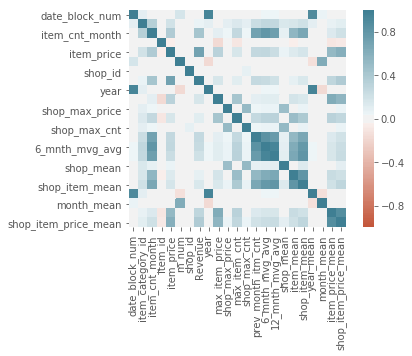

In [38]:
# Correltation matrix heatmap
corr = train_set.corr()

sns.heatmap(corr, vmin=-1, vmax=1, center=0, 
           cmap=sns.diverging_palette(20, 220, n=200), square=True)

Need to get correlation matrix of new features

In [39]:
train_set.corr()

,date_block_num,item_category_id,item_cnt_month,item_id,item_price,m_num,shop_id,Revenue,year,max_item_price,...,prev_month_itm_cnt,6_mnth_mvg_avg,12_mnth_mvg_avg,shop_mean,item_mean,shop_item_mean,year_mean,month_mean,item_price_mean,shop_item_price_mean
date_block_num,1.000000e+00,0.099648,0.032432,-1.915981e-06,0.035686,1.771173e-01,-1.469920e-06,0.007004,9.396459e-01,0.000019,...,0.037372,0.043176,0.046240,-0.000011,-0.000062,-0.000060,9.027004e-01,0.054562,0.000049,0.000040
item_category_id,9.964756e-02,1.000000,0.344462,-3.205189e-03,0.188691,2.275696e-02,9.376085e-03,0.057006,9.185777e-02,0.033897,...,0.232564,0.283029,0.268246,0.151897,0.164607,0.207640,8.795047e-02,0.030087,0.071111,0.104439
item_cnt_month,3.243235e-02,0.344462,1.000000,-2.470229e-02,0.370257,1.696463e-02,2.590914e-03,0.437267,2.657425e-02,0.100007,...,0.715082,0.797078,0.733732,0.085326,0.543838,0.672943,2.803541e-02,0.026994,0.133785,0.196353
item_id,-1.915981e-06,-0.003205,-0.024702,1.000000e+00,-0.046215,-9.615714e-06,-3.363992e-06,-0.019231,1.424535e-06,-0.159458,...,-0.023972,-0.029984,-0.032172,-0.000042,-0.045422,-0.036708,7.052719e-07,-0.000002,-0.088847,-0.077524
item_price,3.568613e-02,0.188691,0.370257,-4.621534e-02,1.000000,1.342563e-02,-6.175581e-04,0.718385,3.106231e-02,0.326731,...,0.269496,0.281334,0.237809,0.053452,0.127962,0.173944,3.251572e-02,0.024443,0.520165,0.596146
m_num,1.771173e-01,0.022757,0.016965,-9.615714e-06,0.013426,1.000000e+00,7.071766e-07,0.009317,-1.703115e-01,-0.000081,...,-0.000378,-0.001314,0.004399,-0.000011,-0.000490,-0.000553,-1.267960e-01,0.628465,-0.000198,-0.000219
shop_id,-1.469920e-06,0.009376,0.002591,-3.363992e-06,-0.000618,7.071766e-07,1.000000e+00,-0.000346,-1.717559e-06,0.000023,...,0.002565,0.002019,0.001169,0.030365,-0.000123,0.003850,-2.467755e-06,0.000001,0.000060,-0.001036
Revenue,7.003654e-03,0.057006,0.437267,-1.923099e-02,0.718385,9.317237e-03,-3.464491e-04,1.000000,3.773108e-03,0.168630,...,0.260920,0.254886,0.196923,0.028388,0.080530,0.152404,5.606531e-03,0.015480,0.292171,0.369476
year,9.396459e-01,0.091858,0.026574,1.424535e-06,0.031062,-1.703115e-01,-1.717559e-06,0.003773,1.000000e+00,0.000047,...,0.037549,0.043686,0.044767,-0.000007,0.000108,0.000132,9.478815e-01,-0.163854,0.000118,0.000116
max_item_price,1.899685e-05,0.033897,0.100007,-1.594578e-01,0.326731,-8.103698e-05,2.252224e-05,0.168630,4.719211e-05,1.000000,...,0.096941,0.113588,0.113115,-0.000068,0.183891,0.148611,4.801031e-05,-0.000176,0.628128,0.548072


If new features are too highly correlated with the features they are created from then we drop them because they don't add anything (unless they are highly correlated with item_cnt)

Try to get features that create new correlations (hopefully with item_cnt), but we can use if shows new correlations that weren't there before.

**High Correlation with item_cnt_day:**
1. 6-month mvg average = 0.79
2. 12-month mvg average = 0.73
3. prev. month item_cnt = 0.72
4. shop_item_mean = 0.67
5. item_mean = 0.54
6. Revenue = 0.44



### XGBoost Feature Importance

In [40]:
# Need to drop month because XGB can't use strings
xgb_set = train_set.drop('Month', axis=1)
xgb_val = validation_set.drop('Month', axis = 1)

In [41]:
# Prepare data for XGBoost
X_train = xgb_set.drop('item_cnt_month', axis=1)
y_train = xgb_set['item_cnt_month']
#val
X_val = xgb_val.drop('item_cnt_month', axis=1)
y_val = xgb_val['item_cnt_month']

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[06:30:37] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


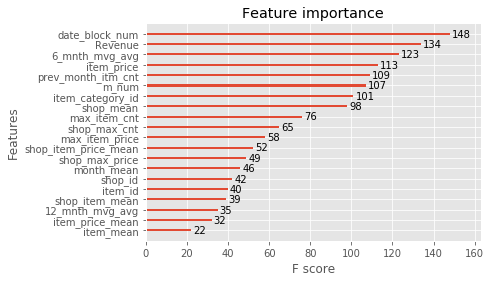

In [42]:
#XGBoost
param = {'max_depth': 8, 'eta': 0.10,
         'seed': 1,
         'eval_metric': 'rmse'}

# Train
xgbtrain = xgb.DMatrix(X_train, y_train)
watchlist = [(xgbtrain, 'train-rmse')]

bst = xgb.train(param, xgbtrain)

# Determine importance of features with XGB graph
xgb.plot_importance(bst)

Revenue and date_block_num have the highest importance. Revenue is likely because the model looks to see if there is any revenue to determine if there are any other items in previous months. 6-month average and shop mean are the next most important. This is to be expected. Strangely, shop_item_mean and item_mean are very low on feature importance. Not sure why because they were higly correlated with item count per month. But maybe this model does not use them as much because it is using others.

### Drop Features

Drop the features that have the lowest importance and correlation

In [43]:
# Drop features

### Final Test Data

We want the final train and test data to have categories of:
item_id
shop_id
cat (the combined category)
month
previous month's sales
previous month's revenue

Test data columns: shop_id, item_id, item_category_id, cat, item_price, date_block_num: 34, Month: Nov, m_num: 11

### Separate Test Data that Does NOT have item_id in Train Data

In [44]:
train_shop_ids = train['shop_id'].unique()
train_item_ids = train['item_id'].unique()
# Only test shops that exist in train set.
lk_test = test[test['shop_id'].isin(train_shop_ids)]
# Only test items that exist in train set.
lk_test = lk_test[lk_test['item_id'].isin(train_item_ids)]

The above code would get us the data that is in both sets. Now we can subtract the items in both train and test from the items in the test set to determine how many items are in only the test set. 

In [45]:
print('Test set size before drop:', test.shape[0])
print('Test set size after drop:', lk_test.shape[0])

Test set size before drop: 214200
Test set size after drop: 198072


So the total number of test values that are not in the train set are:
214,200 - 198,072 = 16,128

This is made up of 363 unique items and '' unique shops

So 16,128 of the 214,200 don't have previous month sales in train data
This is 7.5% of the test set that will not be able to use that data
Maybe this is negligable

## Output


Train and validation sets with mean encoding

In [46]:
train_set.to_csv('Train_set.csv', index=False)

In [47]:
validation_set.to_csv('Val_set.csv')

In [48]:
test_df.to_csv('Test_set.csv')

Traintest Data output (no mean encoding applied)


In [49]:
traintest.to_csv('Traintest.csv', index=False)

We are gonna want to import the entire traintest dataset and then split it at the test data (where date_block_num = 34). 